## Solving the Stefan's Problem using PINN

Reference: https://asmedigitalcollection.asme.org/heattransfer/article/143/6/060801/1104439/Physics-Informed-Neural-Networks-for-Heat-Transfer

PDE 1: $ \frac{∂u_1}{∂t} = k_1 \frac{∂^2u_1}{∂x^2} $ ; $ x \in (0,s) $</br>
PDE 2: $ \frac{∂u_2}{∂t} = k_2 \frac{∂^2u_2}{∂x^2} $ ; $ x \in (s,2) $</br>
PDE 3: $ \frac{∂s}{∂t} = \alpha_1 \frac{∂u_1}{∂x} + \alpha_2 \frac{∂u_2}{∂x}$ </br>
Time Domain: $ t \in [0,1] $</br>
Initial Condition: $ s(0) = s_0 $ </br>
Interface Condition: $ u_1(s) = u_2(s) = u^* $</br>
$ k_1 = 2 $, $ k_2 = 1 $, $\alpha_1 = -2 $, $\alpha_2 = 1 $, $ s_0 = \frac{1}{2}, u^* = 0 $

In [ ]:
import tensorflow as tf

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float
k2 = tf.constant(1., dtype=DTYPE)
k1 = k2*2
s0 = 0.5*k2
a2 = k2
a1 = -k1

def f1(u1_t, u1_xx): # calculates PDE1 value given u1's derivatives
  return u1_t - k1*u1_xx

def f2(u2_t, u2_xx): # calculates PDE2 value given u2's derivatives
  return u2_t - k2*u2_xx

def f3(s_t, u1_x, u2_x): # calculates PDE3 value
  return s_t - a1*u1_x - a2*u2_x

def u1_anal(t,x): # calculates u1 value from its analytical solution
  return 2*(tf.exp((t+0.5-x)/2)-1)

def u2_anal(t,x): # calculates u2 value from its analytical solution
  return tf.exp(t+0.5-x)-1

def s_anal(t): # calculates s value from its analytical solution
  return t+0.5

def u_anal(t,x): # analytical value of u given x and t
  return tf.where(tf.math.greater(s_anal(t),x),u1_anal(t,x),u2_anal(t,x))

In [ ]:
# Training Data

Nm = 200 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(2.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm = tf.random.uniform((Nm,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xm = tf.random.uniform((Nm,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points

In [ ]:
def u_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for u1 and u2
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

In [ ]:
def get_f(umodel, smodel, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = umodel(tf.concat([t, x], axis=1)) # u1 and u2 as functions of t and x
    u1, u2 = u[:, 0:1], u[:, 1:2]
    s = smodel(t)
    tape.watch(s)
    ub = umodel(tf.concat([t, s], axis=1))
    u1b, u2b = ub[:, 0:1], ub[:, 1:2]
    # defined within context to compute 2nd derivatives
    u1_x = tape.gradient(u1, x)
    u2_x = tape.gradient(u2, x)
  s_t = tape.gradient(s, t)
  u1b_x = tape.gradient(u1b, s)
  u2b_x = tape.gradient(u2b, s)
  u1_t = tape.gradient(u1, t)
  u2_t = tape.gradient(u2, t)
  u1_xx = tape.gradient(u1_x, x)
  u2_xx = tape.gradient(u2_x, x)
  del tape
  return f1(u1_t, u1_xx), f2(u2_t, u2_xx), f3(s_t, u1b_x, u2b_x)

In [ ]:
def loss_fxn(umodel, smodel, mea, um, so, coll): # compute Loss given model and data
  init = tf.constant(0,shape=(1,1))
  Li = tf.squeeze(tf.square(smodel(init) - so)) # MSE for initial data
  psb = smodel(coll[:,0:1]) # Interface prediction on collocation data
  pub = umodel(tf.concat([coll[:,0:1], psb], axis=1)) # Interface Temperature prediction
  pu1b, pu2b = pub[:, 0:1], pub[:, 1:2]
  Lb = tf.reduce_mean(tf.square(pu1b)) + tf.reduce_mean(tf.square(pu2b)) # MSE for boundary data
  pum = umodel(mea) # Temperature prediction on measurement data
  pu1m, pu2m = pum[:, 0:1], pum[:, 1:2]
  psm = smodel(mea[:,0:1]) # Interface prediction on measurement data
  pum = tf.where(tf.math.greater(psm,mea[:,1:2]), pu1m, pu2m)
  Lm = tf.reduce_mean(tf.square(um - pum)) # MSE for measurement data
  f_1, f_2, f_3 = get_f(umodel, smodel, coll) # calculate f values given models and collocation data
  Lc = tf.reduce_mean(tf.square(f_1)) + tf.reduce_mean(tf.square(f_2)) + tf.reduce_mean(tf.square(f_3)) # MSE in PDE values for collocation data
  loss = Li + Lb + Lc + Lm
  return loss

In [ ]:
def L_and_grad_Lw(umodel, smodel, mea, um, so, coll): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    loss = loss_fxn(umodel, smodel, mea, um, so, coll) # loss as a function of model (& hence weights)
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  del tape
  return loss, gu, gs

In [ ]:
Nc = 10000 # No of collocation points
umodel = u_model() # initialise the Temp NN model
smodel = s_model() # initialise the Intf NN model
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.legacy.Adam(learning_rate=lr) # Adam optimizer #had to move to legacy circa 27 June 2023

In [ ]:
@tf.function #this line was added circa 27 June 2023
def train_step(coll):
  # compute loss and its gradient wrt model parameters
  loss, gradwu, gradws = L_and_grad_Lw(umodel, smodel, meas, um, s0, coll)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gradwu, umodel.trainable_variables))
  optim.apply_gradients(zip(gradws, smodel.trainable_variables))
  return loss

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
  xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
  coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
  loss = train_step(coll)
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0))
epochs = [i for i in range(1,N+1)]

Final Loss = 8.243981e-06
Computation Time = 424.91859221458435 seconds


Text(0, 0.5, 'Loss')

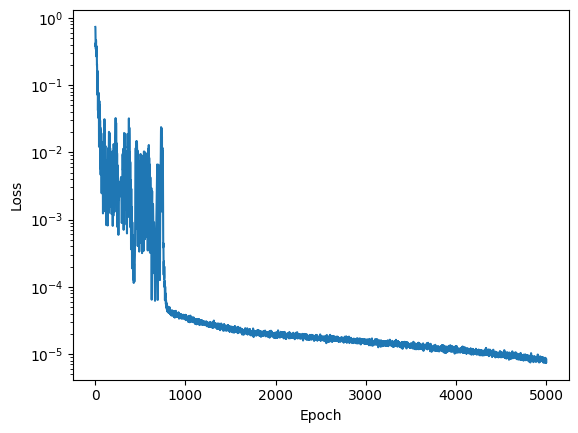

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

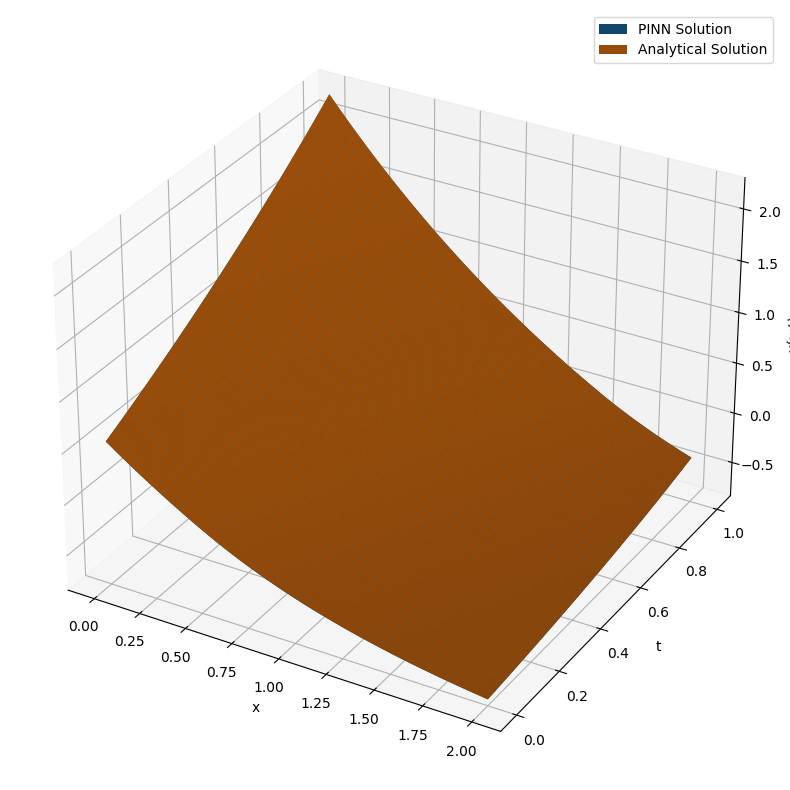

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = umodel(input)
u1_p, u2_p = u_pred[:, 0:1], u_pred[:, 1:2]
s_pred = smodel(T.flatten())
x_inp = np.expand_dims(X.flatten(),-1)
up = tf.where(tf.math.greater(s_pred,x_inp), u1_p, u2_p)
U = up.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, U, label = 'PINN Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X, T, UT, label = 'Analytical Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

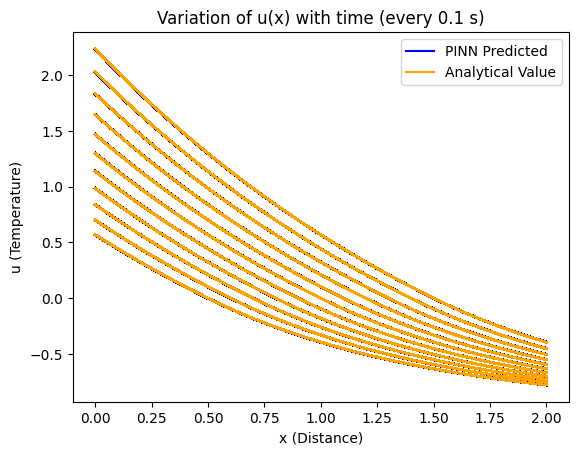

In [ ]:
from IPython import display
from matplotlib.lines import Line2D
from time import sleep
for i in range(0,501,50):
    plt.plot(X,U[:,i],color='blue')
    plt.plot(X,UT[:,i],color='orange')
    plt.xlabel('x (Distance)')
    plt.ylabel('u (Temperature)')
    line1 = Line2D([0], [0], label='PINN Predicted', color='blue')
    line2 = Line2D([0], [0], label='Analytical Value', color='orange')
    plt.legend(handles=[line1,line2])
    plt.title('Variation of u(x) with time (every 0.1 s)')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(0.5)

Text(0.5, 1.0, 'Predicted vs Actual Movement of Interface')

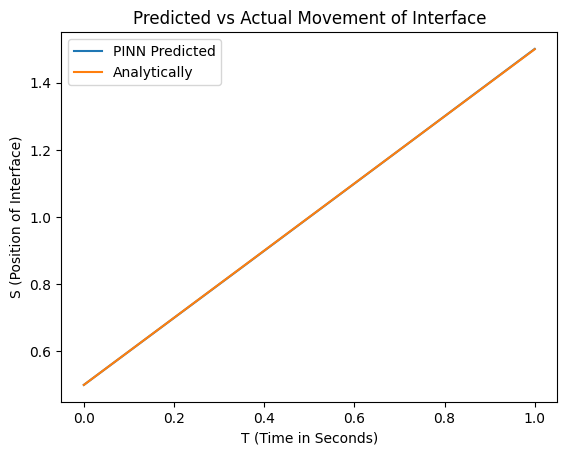

In [ ]:
t_values = tf.cast(tspace,DTYPE)
s_values = smodel(t_values)
s_exact = s_anal(t_values)
plt.plot(t_values,s_values)
plt.plot(t_values,s_exact)
plt.legend(['PINN Predicted','Analytically'])
plt.xlabel('T (Time in Seconds)')
plt.ylabel('S (Position of Interface)')
plt.title('Predicted vs Actual Movement of Interface')

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(UT.flatten(), U.flatten()), mean_squared_error(s_values, s_exact)

(4.734818e-07, 5.4550537e-08)

In [ ]:
import pickle
filename = 'stef_u_model.sav'
pickle.dump(umodel, open(filename, 'wb'))
filename2 = 'stef_s_model.sav'
pickle.dump(smodel, open(filename2, 'wb'))